In [1]:
import io, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, box
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import contextily as ctx
from h3.api.basic_str import get_resolution, grid_disk

In [2]:
try:
    from libpysal.weights import W, Queen, KNN
    from esda.moran import Moran_Local
except Exception as e:
    raise ImportError(
        "需要安装 PySAL 组件：libpysal 与 esda。\n"
        "例如：pip install libpysal esda"
    ) from e

In [3]:
BASE = Path("/users/eleves-b/2023/wenrui.dai/Desktop/environment/Helsinki/")
GPKG = BASE / "TD_415_diff.gpkg"
GTFS = BASE / "GTFS.zip"
CRS_PLOT = "EPSG:3857"
BASEMAP = ctx.providers.CartoDB.PositronNoLabels

In [4]:
ZERO = "#ADADAD"
RED5 = ['#FCE1E1','#F2B1B1','#FC4242','#8F0606','#2E0000']
BLUE5= ['#0B1F51','#22479D','#4D7BBD','#8FBFE0','#C7E0F3']

ROUTE_STYLE = {
    1:   {"color": "#7B1FA2", "lw": 1.2, "label": "Subway"},
    0:   {"color": "#2E7D32", "lw": 1.2, "label": "Tram/LRT"},
    109: {"color": "#FF8F00", "lw": 1.2, "label": "Rail"},
}
MODE_TO_RT = {"subway": 1, "tram": 0, "rail": 109}

In [5]:
gdf = gpd.read_file(GPKG)
if gdf.crs is None:
    raise ValueError("GPKG 没有 CRS，请先为数据设置正确的坐标系。")
gdf = gdf.to_crs(CRS_PLOT)

NEEDED = [
    "total_emission_m","total_emission_n",
    "total_emission_subway_m","total_emission_tram_m","total_emission_rail_m","total_emission_bus_m",
    "total_emission_subway_n","total_emission_tram_n","total_emission_rail_n","total_emission_bus_n",
    "emission_diff",
]
for c in NEEDED:
    if c in gdf.columns:
        gdf[c] = pd.to_numeric(gdf[c], errors="coerce")

In [6]:
def read_from_zip(zip_path, name, usecols=None, dtype=str):
    with zipfile.ZipFile(zip_path) as z:
        with z.open(name) as f:
            return pd.read_csv(io.TextIOWrapper(f, encoding="utf-8"), dtype=dtype, usecols=usecols)

In [7]:
routes = read_from_zip(GTFS, "routes.txt",
                       usecols=["route_id","route_type","route_short_name","route_long_name"])
trips  = read_from_zip(GTFS, "trips.txt",
                       usecols=["route_id","trip_id","shape_id"])
shapes = read_from_zip(GTFS, "shapes.txt",
                       usecols=["shape_id","shape_pt_lat","shape_pt_lon","shape_pt_sequence"])

routes["route_type"] = pd.to_numeric(routes["route_type"], errors="coerce").astype("Int64")
trips  = trips.dropna(subset=["shape_id"])
shapes["shape_pt_sequence"] = pd.to_numeric(shapes["shape_pt_sequence"], errors="coerce")
shapes["shape_pt_lat"] = pd.to_numeric(shapes["shape_pt_lat"], errors="coerce")
shapes["shape_pt_lon"] = pd.to_numeric(shapes["shape_pt_lon"], errors="coerce")

In [8]:
RT_KEEP = {0: "Tram/LRT", 1: "Subway", 109: "Rail"}
rt = trips.merge(routes[["route_id","route_type"]], on="route_id", how="left")
rt = rt[rt["route_type"].isin(RT_KEEP.keys())].dropna(subset=["shape_id"])
shape_ids = set(rt["shape_id"].unique())

shapes_sel = shapes[shapes["shape_id"].isin(shape_ids)].dropna(
    subset=["shape_pt_lat","shape_pt_lon","shape_pt_sequence"]
).sort_values(["shape_id","shape_pt_sequence"])

lines = []
for sid, grp in shapes_sel.groupby("shape_id", sort=False):
    coords = list(zip(grp["shape_pt_lon"].values, grp["shape_pt_lat"].values))
    if len(coords) >= 2:
        lines.append({"shape_id": sid, "geometry": LineString(coords)})

g_shapes = gpd.GeoDataFrame(lines, crs="EPSG:4326")
g_shapes = g_shapes.merge(rt[["shape_id","route_type"]].drop_duplicates(), on="shape_id", how="left")
g_shapes = g_shapes.to_crs(CRS_PLOT)

In [9]:
def _extent(ax, g, pad_frac=0.035, min_pad=800):
    xmin, ymin, xmax, ymax = g.total_bounds
    w, h = (xmax - xmin), (ymax - ymin)
    dx = max(w * pad_frac, min_pad)
    dy = max(h * pad_frac, min_pad)
    ax.set_xlim(xmin - dx, xmax + dx)
    ax.set_ylim(ymin - dy, ymax + dy)
    ax.set_aspect(1.0, adjustable="datalim")

def _add_basemap(ax):
    ctx.add_basemap(ax, source=BASEMAP, crs=CRS_PLOT, alpha=1.0, attribution_size=6)

def overlay_routes(ax, mode):
    if mode in MODE_TO_RT:
        rtype = MODE_TO_RT[mode]
        st = ROUTE_STYLE[rtype]
        sub = g_shapes[g_shapes["route_type"] == rtype]
        if len(sub):
            sub.plot(ax=ax, color=st["color"], linewidth=st["lw"], alpha=0.6, zorder=6,
                     linestyle=st.get("ls","-"))
    elif mode == "bus":
        for rtype in (1,0,109):
            st = ROUTE_STYLE[rtype]
            sub = g_shapes[g_shapes["route_type"] == rtype]
            if len(sub):
                sub.plot(ax=ax, color=st["color"], linewidth=max(0.8, st["lw"]*0.5),
                         alpha=0.25, zorder=6, linestyle=st.get("ls","-"))

In [10]:
def handles_route_legend_for_mode(mode):
    if mode == "bus":
        return [
            Line2D([0],[0], color=ROUTE_STYLE[1]["color"],   lw=max(0.8, ROUTE_STYLE[1]["lw"]*0.6), alpha=0.35, label="Subway"),
            Line2D([0],[0], color=ROUTE_STYLE[0]["color"],   lw=max(0.8, ROUTE_STYLE[0]["lw"]*0.6), alpha=0.35, label="Tram/LRT"),
            Line2D([0],[0], color=ROUTE_STYLE[109]["color"], lw=max(0.8, ROUTE_STYLE[109]["lw"]*0.6), alpha=0.35, label="Rail"),
        ]
    else:
        rtype = MODE_TO_RT[mode]; st = ROUTE_STYLE[rtype]
        return [Line2D([0],[0], color=st["color"], lw=st["lw"], label=st["label"])]

In [11]:
def build_weights_for_lisa(gdf_in: gpd.GeoDataFrame, h3_col="from_id", patch_k=2):
    if h3_col not in gdf_in.columns:
        raise ValueError(f"缺少 H3 列：{h3_col}")

    ids = gdf_in[h3_col].astype(str).tolist()
    idset = set(ids)

    res_set = {get_resolution(h) for h in ids}
    if len(res_set) != 1:
        raise ValueError(f"H3 分辨率需一致，当前检测到：{res_set}")

    neighbors = {h: [n for n in grid_disk(h, 1) if n in idset and n != h] for h in ids}

    if patch_k and patch_k > 1:
        for h, nbrs in list(neighbors.items()):
            if not nbrs:
                cand = [n for n in grid_disk(h, patch_k) if n in idset and n != h]
                if cand:
                    neighbors[h] = [cand[0]]

    for h, nbrs in list(neighbors.items()):
        for n in nbrs:
            if n in idset:
                neighbors.setdefault(n, [])
                if h not in neighbors[n]:
                    neighbors[n].append(h)

    w = W(neighbors, ids=ids)
    w.transform = "R"
    return w, f"H3 contiguity (k=1, patch k={patch_k})"


def compute_lisa(gdf_in: gpd.GeoDataFrame, value_col: str,
                 permutations: int = 999, p_threshold: float = 0.05,
                 h3_col: str = "from_id"):
    if value_col not in gdf_in.columns:
        raise ValueError(f"找不到数值列：{value_col}")

    g = gdf_in.copy()
    y = pd.to_numeric(g[value_col], errors="coerce").astype(float)

    order = ["High-High","Low-Low","High-Low","Low-High","Not Sig"]
    if y.nunique(dropna=False) <= 1:
        g["LISA_CAT"] = pd.Categorical(["Not Sig"] * len(g), categories=order, ordered=True)
        g["LISA_I"]   = np.nan
        g["LISA_p"]   = 1.0
        g["LISA_w"]   = "degenerate (constant)"
        return g

    w, wname = build_weights_for_lisa(g, h3_col=h3_col, patch_k=2)

    lisa = Moran_Local(y.fillna(0.0).values, w, permutations=permutations)

    q = lisa.q
    sig = lisa.p_sim < p_threshold

    cat = np.array(["Not Sig"] * len(g), dtype=object)
    cat[(q==1) & sig] = "High-High"
    cat[(q==2) & sig] = "Low-High"
    cat[(q==3) & sig] = "Low-Low"
    cat[(q==4) & sig] = "High-Low"

    g["LISA_CAT"] = pd.Categorical(cat, categories=order, ordered=True)
    g["LISA_I"]   = lisa.Is
    g["LISA_p"]   = lisa.p_sim
    g["LISA_w"]   = wname
    return g

In [12]:
LISA_COLORS = {
    "High-High": "#b2182b",
    "Low-Low":   "#2166ac",
    "High-Low":  "#ef8a62",
    "Low-High":  "#67a9cf",
    "Not Sig":   "#d9d9d9",
}
def handles_lisa_legend():
    order = ["High-High","Low-Low","High-Low","Low-High","Not Sig"]
    return [Patch(facecolor=LISA_COLORS[c], edgecolor="white", label=c) for c in order]

def plot_lisa_map(g_with_lisa: gpd.GeoDataFrame, title: str,
                  overlay_mode: str | None = None, figsize=(10,10), savepath: Path | None = None):
    if not isinstance(g_with_lisa, gpd.GeoDataFrame):
        raise TypeError(f"传入的不是 GeoDataFrame，而是 {type(g_with_lisa)}")
    if "LISA_CAT" not in g_with_lisa.columns:
        raise KeyError("输入缺少 LISA_CAT；请确认 compute_lisa() 是否正确返回了结果。")

    fig, ax = plt.subplots(figsize=figsize)
    _extent(ax, g_with_lisa); _add_basemap(ax)

    cats = ["High-High","Low-Low","High-Low","Low-High","Not Sig"]
    for cat in cats:
        sub = g_with_lisa[g_with_lisa["LISA_CAT"] == cat]
        if len(sub):
            sub.plot(ax=ax, color=LISA_COLORS[cat], edgecolor="white",
                     linewidth=0.05, zorder=3, label=cat)

    if overlay_mode:
        overlay_routes(ax, overlay_mode)

    leg = ax.legend(handles=handles_lisa_legend(),
                    title="Local Moran's I clusters (p<0.05)",
                    loc="upper left", frameon=True, fontsize=9, title_fontsize=10)
    leg._legend_box.align = "left"

    ax.set_axis_off()
    ax.set_title(title, fontsize=13)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

In [13]:
def plot_lisa_by_mode_total(suffix: str, title_prefix: str):
    """
    suffix: 'm' 或 'n'（与你列命名一致，如 total_emission_subway_m）
    """
    mode_to_col = {
        "subway": f"total_emission_subway_{suffix}",
        "tram":   f"total_emission_tram_{suffix}",
        "rail":   f"total_emission_rail_{suffix}",
        "bus":    f"total_emission_bus_{suffix}",
    }
    modes = ["subway","tram","rail","bus"]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                             gridspec_kw={'hspace': 0.06, 'wspace': 0.10})
    axes = axes.ravel()

    for i, (ax, mode) in enumerate(zip(axes, modes)):
        col = mode_to_col[mode]
        g_lisa = compute_lisa(gdf, value_col=col, permutations=999, p_threshold=0.05)

        _extent(ax, g_lisa); _add_basemap(ax)
        for cat in ["High-High","Low-Low","High-Low","Low-High","Not Sig"]:
            sub = g_lisa[g_lisa["LISA_CAT"] == cat]
            if len(sub):
                sub.plot(ax=ax, color=LISA_COLORS[cat], edgecolor="white",
                         linewidth=0.05, zorder=3)

        overlay_routes(ax, mode)
        ax.legend(handles=handles_route_legend_for_mode(mode),
                  loc="lower right", frameon=True, fontsize=9, title=None)

        title_pad = 6 if i < 2 else 8
        ax.set_axis_off(); ax.set_title(f"{title_prefix} — {mode}", fontsize=12, pad=title_pad)

    fig.subplots_adjust(top=0.9)
    fig.legend(handles=handles_lisa_legend(), title="Local Moran's I (p<0.05)",
               loc="upper center", bbox_to_anchor=(0.5, 0.99),
               ncol=5, frameon=True, fontsize=10, title_fontsize=11, borderaxespad=0.0)
    plt.show()

def plot_lisa_by_mode_diff(title_prefix: str = "LISA — Emission Difference"):
    for md in ["subway","tram","rail","bus"]:
        col = f"emission_diff_{md}"
        mcol, ncol = f"total_emission_{md}_m", f"total_emission_{md}_n"
        if col not in gdf.columns and {mcol, ncol}.issubset(gdf.columns):
            gdf[col] = pd.to_numeric(gdf[mcol], errors="coerce") - pd.to_numeric(gdf[ncol], errors="coerce")

    modes = ["subway","tram","rail","bus"]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                             gridspec_kw={'hspace': 0.06, 'wspace': 0.10})
    axes = axes.ravel()

    for i, (ax, mode) in enumerate(zip(axes, modes)):
        col = f"emission_diff_{mode}"
        g_lisa = compute_lisa(gdf, value_col=col, permutations=999, p_threshold=0.05)

        _extent(ax, g_lisa); _add_basemap(ax)
        for cat in ["High-High","Low-Low","High-Low","Low-High","Not Sig"]:
            sub = g_lisa[g_lisa["LISA_CAT"] == cat]
            if len(sub):
                sub.plot(ax=ax, color=LISA_COLORS[cat], edgecolor="white",
                         linewidth=0.05, zorder=3)

        overlay_routes(ax, mode)
        ax.legend(handles=handles_route_legend_for_mode(mode),
                  loc="lower right", frameon=True, fontsize=9, title=None)

        title_pad = 6 if i < 2 else 8
        ax.set_axis_off(); ax.set_title(f"{title_prefix} — {mode}", fontsize=12, pad=title_pad)

    fig.subplots_adjust(top=0.9)
    fig.legend(handles=handles_lisa_legend(), title="Local Moran's I (p<0.05)",
               loc="upper center", bbox_to_anchor=(0.5, 0.99),
               ncol=5, frameon=True, fontsize=10, title_fontsize=11, borderaxespad=0.0)
    plt.show()

/tmp/ipykernel_1259940/272672110.py:28: UserWarning: The weights matrix is not fully connected: 
 There are 190 disconnected components.
 There are 22 islands with ids: 89089961323ffff, 89089961357ffff, 8908996145bffff, 89089961643ffff, 89089961b07ffff, 8908996a9abffff, 8908996aed7ffff, 8908996c243ffff, 8908996cc5bffff, 8908996ccc3ffff, 8908996dc47ffff, 8908996f1d7ffff, 8908996f69bffff, 89089979a2fffff, 89089979b87ffff, 891126c2a07ffff, 891126c2e57ffff, 891126d110bffff, 891126d244fffff, 891126d4183ffff, 891126d60cbffff, 891126d746fffff.
  w = W(neighbors, ids=ids)


('WARNING: ', '89089961323ffff', ' is an island (no neighbors)')
('WARNING: ', '89089961357ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996145bffff', ' is an island (no neighbors)')
('WARNING: ', '89089961643ffff', ' is an island (no neighbors)')
('WARNING: ', '89089961b07ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996a9abffff', ' is an island (no neighbors)')
('WARNING: ', '8908996aed7ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996c243ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996cc5bffff', ' is an island (no neighbors)')
('WARNING: ', '8908996ccc3ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996dc47ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996f1d7ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996f69bffff', ' is an island (no neighbors)')
('WARNING: ', '89089979a2fffff', ' is an island (no neighbors)')
('WARNING: ', '89089979b87ffff', ' is an island (no neighbors)')
('WARNING: ', '891126c2a0

/users/eleves-b/2023/wenrui.dai/miniconda3/envs/sustainability-gis/lib/python3.11/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


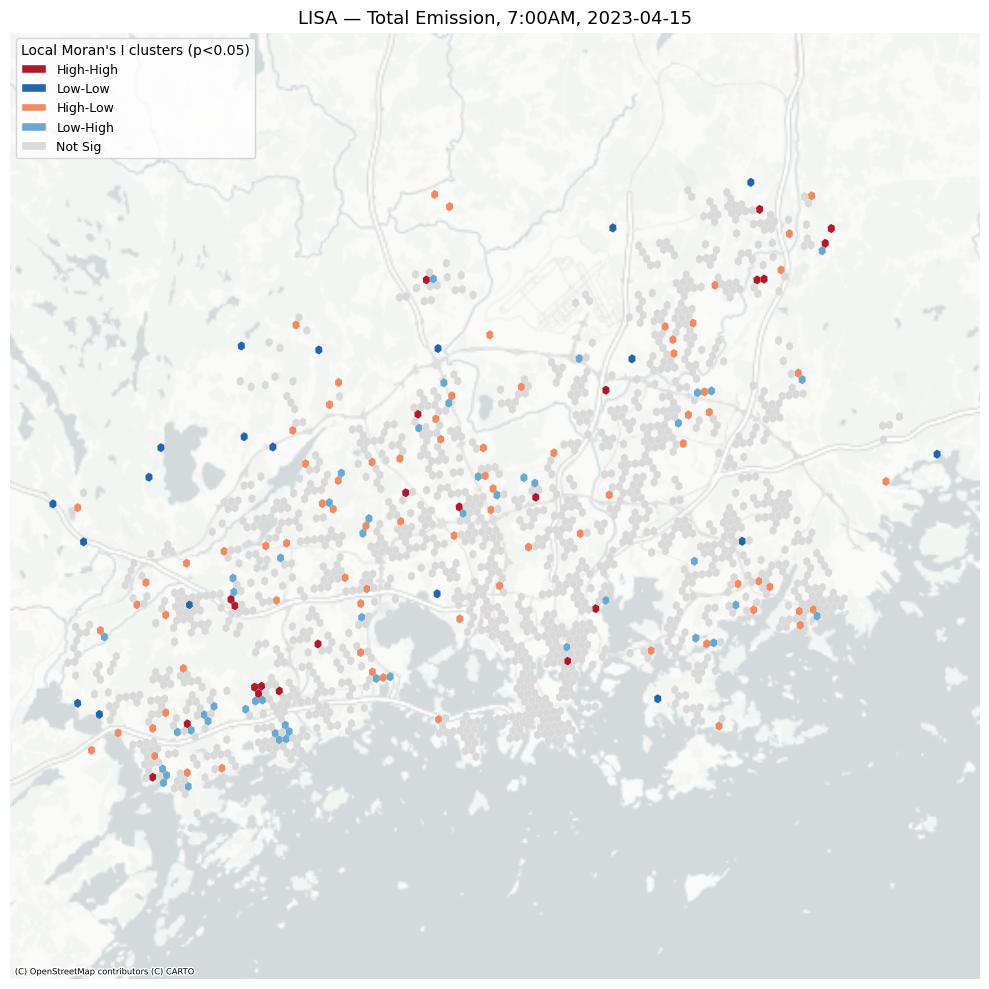

In [14]:
#LISA — Total Emission (Morning)
g_lisa_m = compute_lisa(gdf, value_col="total_emission_m", permutations=999, p_threshold=0.05, h3_col="from_id")
plot_lisa_map(g_lisa_m, title="LISA — Total Emission, 7:00AM, 2023-04-15", overlay_mode=None)

In [ ]:
#LISA — Total Emission by Mode (Morning)
plot_lisa_by_mode_total(suffix="m", title_prefix="LISA — Emission By Mode, 7:00AM, 2023-04-15")

/tmp/ipykernel_1259940/272672110.py:28: UserWarning: The weights matrix is not fully connected: 
 There are 190 disconnected components.
 There are 22 islands with ids: 89089961323ffff, 89089961357ffff, 8908996145bffff, 89089961643ffff, 89089961b07ffff, 8908996a9abffff, 8908996aed7ffff, 8908996c243ffff, 8908996cc5bffff, 8908996ccc3ffff, 8908996dc47ffff, 8908996f1d7ffff, 8908996f69bffff, 89089979a2fffff, 89089979b87ffff, 891126c2a07ffff, 891126c2e57ffff, 891126d110bffff, 891126d244fffff, 891126d4183ffff, 891126d60cbffff, 891126d746fffff.
  w = W(neighbors, ids=ids)
/users/eleves-b/2023/wenrui.dai/miniconda3/envs/sustainability-gis/lib/python3.11/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


('WARNING: ', '89089961323ffff', ' is an island (no neighbors)')
('WARNING: ', '89089961357ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996145bffff', ' is an island (no neighbors)')
('WARNING: ', '89089961643ffff', ' is an island (no neighbors)')
('WARNING: ', '89089961b07ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996a9abffff', ' is an island (no neighbors)')
('WARNING: ', '8908996aed7ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996c243ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996cc5bffff', ' is an island (no neighbors)')
('WARNING: ', '8908996ccc3ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996dc47ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996f1d7ffff', ' is an island (no neighbors)')
('WARNING: ', '8908996f69bffff', ' is an island (no neighbors)')
('WARNING: ', '89089979a2fffff', ' is an island (no neighbors)')
('WARNING: ', '89089979b87ffff', ' is an island (no neighbors)')
('WARNING: ', '891126c2a0

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


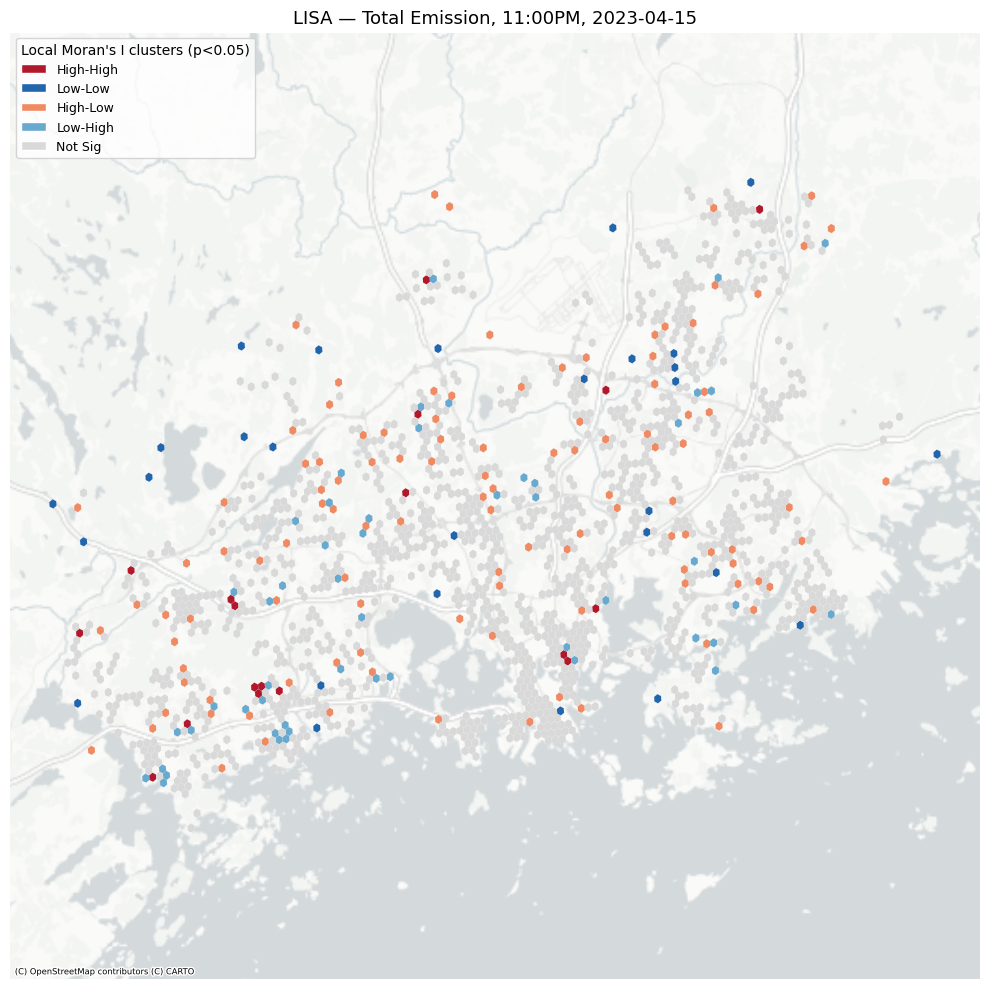

In [15]:
#LISA — Total Emission (Night)
g_lisa_n = compute_lisa(gdf, value_col="total_emission_n", permutations=999, p_threshold=0.05, h3_col="from_id")
plot_lisa_map(g_lisa_n, title="LISA — Total Emission, 11:00PM, 2023-04-15", overlay_mode=None)

In [ ]:
#LISA — Total Emission by Mode (Night)
plot_lisa_by_mode_total(suffix="n", title_prefix="LISA — Emission By Mode, 11:00PM, 2023-04-15")

In [ ]:
#LISA — Emission Difference 
g_lisa_diff = compute_lisa(gdf, value_col="emission_diff", permutations=999, p_threshold=0.05)
plot_lisa_map(g_lisa_diff, title="LISA — Total Emission Difference, 2023-04-15", overlay_mode="None")

In [ ]:
#LISA — Emission Difference by Mode
plot_lisa_by_mode_diff(title_prefix="LISA — Emission Difference By Mode, 2023-04-15")